## Import statements

In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
from keras.metrics import MeanIoU
from sklearn.model_selection import train_test_split
import cv2
import time
from glob import glob
from tqdm import tqdm
from operator import add
import json  # for saving the results
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score, roc_curve, auc
from google.colab import drive
from torch.cuda.amp import autocast
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Print device information
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Available memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA version: 12.4
GPU: NVIDIA L4
Available memory: 23.80 GB


## Dataset

In [ ]:
# Create Dataset class
class DriveDataset(Dataset):
    def __init__(self, images_path, masks_path):
        # Filter out non-image files (like Thumbs.db)
        valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff']

        # Filter image paths
        filtered_images = []
        for path in images_path:
            ext = os.path.splitext(path)[1].lower()
            if ext in valid_extensions:
                filtered_images.append(path)


        # Ensure one-to-one correspondence between images and masks
        self.images_path = []
        self.masks_path = []


        # Get base filenames of images and masks (without path and extension)
        image_basenames = [os.path.splitext(os.path.basename(p))[0] for p in filtered_images]
        mask_basenames = [os.path.splitext(os.path.basename(p))[0] for p in masks_path]

        # Only keep files that exist in both images and masks
        for i, img_path in enumerate(filtered_images):
            img_basename = image_basenames[i]
            # Find corresponding mask
            matching_masks = [j for j, m in enumerate(mask_basenames) if m == img_basename]
            if matching_masks:
                # Found matching mask
                mask_idx = matching_masks[0]
                self.images_path.append(img_path)
                self.masks_path.append(masks_path[mask_idx])



        self.n_samples = len(self.images_path)
        print(f"Valid samples count: {self.n_samples}")

        if self.n_samples == 0:
            print("Warning: No valid image-mask pairs found!")
            print(f"Original image paths count: {len(images_path)}")
            print(f"Filtered image paths count: {len(filtered_images)}")
            print(f"Original mask paths count: {len(masks_path)}")

            # Print some example paths for debugging
            if len(images_path) > 0:
                print(f"Example image path: {images_path[0]}")
            if len(masks_path) > 0:
                print(f"Example mask path: {masks_path[0]}")

        self.size = (384, 384)  # Use globally defined size

    def __getitem__(self, index):
        # Get an item from the dataset
        if index >= self.n_samples:
            raise IndexError(f"Index {index} out of range (0-{self.n_samples-1})")

        """ Reading image """
        try:
            image = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
            if image is None:
                # Handle reading failure
                print(f"Cannot read image: {self.images_path[index]}")
                # Create an empty image
                image = np.zeros((self.size[0], self.size[1], 3), dtype=np.uint8)

            # Resize image to the defined size
            if image.shape[0] != self.size[0] or image.shape[1] != self.size[1]:
                image = cv2.resize(image, (self.size[1], self.size[0]))  # Note cv2.resize needs (width, height)

            image = image/255.0 # Normalize image
            image = np.transpose(image, (2, 0, 1)) # Change shape to (C, H, W)
            image = image.astype(np.float32) # Convert to float32
            image = torch.from_numpy(image) # Convert to PyTorch tensor
        except Exception as e:
            print(f"Error processing image {self.images_path[index]}: {e}")
            # Create an empty image
            image = torch.zeros((3, self.size[0], self.size[1]), dtype=torch.float32)

        """ Reading mask """
        try:
            mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)
            if mask is None:
                # Handle reading failure
                print(f"Cannot read mask: {self.masks_path[index]}")
                # Create an empty mask
                mask = np.zeros((self.size[0], self.size[1]), dtype=np.uint8)

            # Resize mask to the defined size
            if mask.shape[0] != self.size[0] or mask.shape[1] != self.size[1]:
                mask = cv2.resize(mask, (self.size[1], self.size[0]))  # Note cv2.resize needs (width, height)

            # Ensure mask is binary
            if np.max(mask) > 1:
                mask = (mask > 127).astype(np.uint8) * 255

            mask = mask / 255.0 # Normalize mask
            mask = np.expand_dims(mask, axis=0) # Add channel dimension
            mask = mask.astype(np.float32) # Convert to float32
            mask = torch.from_numpy(mask) # Convert to PyTorch tensor
        except Exception as e:
            print(f"Error processing mask {self.masks_path[index]}: {e}")
            # Create an empty mask
            mask = torch.zeros((1, self.size[0], self.size[1]), dtype=torch.float32)

        return image, mask # Return the image and mask

    def __len__(self):
        return self.n_samples # Return the number of samples in the dataset



## Model Shared Architecture

In [ ]:
# Building U-Net architecture components
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        # Define two convolutional layers with batch normalization and ReLU activation
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        # Forward pass through the convolutional block
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x # Return the output


class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        # Define an encoder block consisting of a convolutional block and max pooling
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        # Forward pass through the encoder block
        x = self.conv(inputs)
        p = self.pool(x) # Apply max pooling
        return x, p # Return the output and pooled feature


class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        # Define a decoder block consisting of a transposed convolution and a convolutional block
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c) # Concatenate skip connections


    def forward(self, inputs, skip):
        # Forward pass through the decoder block
        x = self.up(inputs)  # Upsample the input
        x = torch.cat([x, skip], axis=1)  # Concatenate with skip connection
        x = self.conv(x)  # Apply convolution
        return x  # Return the output


## Unet Architecture

In [ ]:
class build_unet(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        # Bottleneck
        self.b = conv_block(512, 1024)

        # Decoder
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        # Classifier
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        # Encoder
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        # Bottleneck
        b = self.b(p4)

        # Decoder
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)
        return outputs



## Wnet Architecture

In [ ]:

class build_wnet(nn.Module):
    def __init__(self):
        super().__init__()
        # First U-Net
        self.unet1 = FirstUNet()
        # Second U-Net
        self.unet2 = SecondUNet()

    def forward(self, inputs):
        # First U-Net forward pass
        out1 = self.unet1(inputs)
        # Concatenate original input with first U-Net output
        combined = torch.cat([inputs, torch.sigmoid(out1)], dim=1)
        # Second U-Net forward pass
        out2 = self.unet2(combined)
        return out1, out2  # Return both outputs for deep supervision


class FirstUNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        # Bottleneck
        self.b = conv_block(512, 1024)

        # Decoder
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        # Output
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        b = self.b(p4)

        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)
        return outputs


class SecondUNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder (注意输入通道数增加了1，因为连接了第一个U-Net的输出)
        self.e1 = encoder_block(4, 64)  # 3 + 1 channels input
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        # Bottleneck
        self.b = conv_block(512, 1024)

        # Decoder
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        # Output
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        b = self.b(p4)

        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)
        return outputs

## Loss Functions

In [ ]:
# Loss functions
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        # Apply sigmoid to inputs
        inputs = torch.sigmoid(inputs)

        # Flatten inputs and targets
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

        return 1 - dice


class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

# Loss functions
class DiceBCELossWnet(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELossWnet, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, inputs, targets, smooth=1):
        # Keep original shapes for BCE loss
        bce_loss = self.bce(inputs, targets)

        # Calculate Dice Loss
        inputs_sigmoid = torch.sigmoid(inputs)

        # Flatten inputs and targets for Dice loss calculation
        inputs_sigmoid = inputs_sigmoid.view(-1)
        targets_flat = targets.view(-1)

        intersection = (inputs_sigmoid * targets_flat).sum()
        dice_loss = 1 - (2. * intersection + smooth) / (inputs_sigmoid.sum() + targets_flat.sum() + smooth)

        # Combine losses
        Dice_BCE = bce_loss + dice_loss

        return Dice_BCE

# 修改WNetLoss以适应新的DiceBCELoss
class WNetLoss(nn.Module):
    def __init__(self, alpha=0.4):
        super().__init__()
        self.alpha = alpha
        self.dice_bce = DiceBCELossWnet()

    def forward(self, outputs, target):
        out1, out2 = outputs
        # 计算两个输出的损失
        loss1 = self.dice_bce(out1, target)
        loss2 = self.dice_bce(out2, target)
        # 组合损失
        total_loss = self.alpha * loss1 + (1 - self.alpha) * loss2
        return total_loss



## Helpers

In [ ]:
# Helper functions
def seeding(seed):
    """Set seed for reproducibility"""
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


def create_dir(path):
    """Create a directory if it doesn't exist"""
    if not os.path.exists(path):
        os.makedirs(path) # Create the directory


def epoch_time(start_time, end_time):
    """Calculate time taken for each epoch"""
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60) # Convert to minutes
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60)) # Remaining seconds
    return elapsed_mins, elapsed_secs # Return minutes and seconds

train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []


In [ ]:
# this is only for unet - we have a revised version of the function for wnet
def train(model, loader, optimizer, loss_fn, device):
    """Training function"""
    epoch_loss = 0.0
    model.train()

    # Ensure loader is a DataLoader and not a Dataset
    if not isinstance(loader, DataLoader):
        raise TypeError("loader must be of type DataLoader, not Dataset")

    for x, y in loader:
        # Ensure x and y are 4D tensors
        if x.dim() != 4:
            raise ValueError(f"Input x should be a 4D tensor, but got {x.dim()}D tensor with shape {x.shape}")
        if y.dim() != 4:
            raise ValueError(f"Input y should be a 4D tensor, but got {y.dim()}D tensor with shape {y.shape}")

        # Move data to device
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        # Forward pass
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)

        # Backward pass
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()


    train_accuracy = calculate_metrics(y.cpu().numpy(), y_pred.cpu().detach().numpy())[4]  # accuracy is at index 4
    train_accuracies.append(train_accuracy)

    epoch_loss = epoch_loss / len(loader)
    train_losses.append(epoch_loss)
    return epoch_loss

In [ ]:
# this is only for unet - we have a revised version of the function for wnet
def evaluate(model, loader, loss_fn, device):
    """Evaluation function"""
    epoch_loss = 0.0

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()

        epoch_loss = epoch_loss / len(loader)


    valid_accuracy = calculate_metrics(y.cpu().numpy(), y_pred.cpu().detach().numpy())[4]  # accuracy is at index 4
    valid_accuracies.append(valid_accuracy)

    epoch_loss = epoch_loss / len(loader)
    valid_losses.append(epoch_loss)

    return epoch_loss



In [ ]:
# this is only for unet - we have a revised version of the function for wnet
def calculate_metrics(y_true, y_pred):
    """ Ground truth """
    # Check input type, ensure it's NumPy array
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.cpu().numpy()
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.cpu().numpy()

    # Ensure it's a 1D array
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    # Ensure it's binary array
    if np.max(y_true) > 1 or np.max(y_pred) > 1:
        y_true = (y_true > 0.5).astype(np.int64)
        y_pred = (y_pred > 0.5).astype(np.int64)

    # Calculate metrics
    score_jaccard = jaccard_score(y_true, y_pred)
    score_f1 = f1_score(y_true, y_pred)
    score_recall = recall_score(y_true, y_pred)
    score_precision = precision_score(y_true, y_pred)
    score_acc = accuracy_score(y_true, y_pred)

    return [score_jaccard, score_f1, score_recall, score_precision, score_acc]


def mask_parse(mask):
    """Parse mask for visualization"""
    mask = np.expand_dims(mask, axis=-1)    ## (512, 512, 1)
    mask = np.concatenate([mask, mask, mask], axis=-1)  ## (512, 512, 3)
    return mask

### Revised train, evaluate and calculate metrics functions for wnet

In [ ]:
def train_wnet(model, loader, optimizer, loss_fn, device, train_losses, scaler=None, accumulation_steps=1):
    """Training function with mixed precision and gradient accumulation support"""
    epoch_loss = 0.0
    model.train()

    if not isinstance(loader, DataLoader):
        raise TypeError("loader must be of type DataLoader, not Dataset")

    optimizer.zero_grad()
    progress_bar = tqdm(loader, desc="Training", leave=False)

    step_counter = 0

    for x, y in progress_bar:
        if x.dim() != 4:
            raise ValueError(f"Input x should be a 4D tensor, but got {x.dim()}D tensor with shape {x.shape}")
        if y.dim() != 4:
            raise ValueError(f"Input y should be a 4D tensor, but got {y.dim()}D tensor with shape {y.shape}")

        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        if scaler is not None:
            with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                outputs = model(x)
                loss = loss_fn(outputs, y)
                loss = loss / accumulation_steps

            scaler.scale(loss).backward()
            epoch_loss += loss.item() * accumulation_steps
            train_losses.append(loss.item() * accumulation_steps)

            step_counter += 1
            if step_counter % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
        else:
            outputs = model(x)
            loss = loss_fn(outputs, y)
            loss = loss / accumulation_steps

            loss.backward()
            epoch_loss += loss.item() * accumulation_steps
            train_losses.append(loss.item() * accumulation_steps)

            step_counter += 1
            if step_counter % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

        progress_bar.set_postfix(loss=f"{loss.item() * accumulation_steps:.4f}")


    # Get model prediction for last batch
    out1, out2 = outputs  # Assuming model returns two outputs
    y_pred = torch.sigmoid(out2) # Assuming out2 is the relevant output


    train_accuracy = calculate_metrics_wnet(y.cpu().numpy(), y_pred.cpu().detach().numpy())[4]  # accuracy is at index 4
    train_accuracies.append(train_accuracy)

    epoch_loss = epoch_loss / len(loader)
    return epoch_loss


def evaluate_wnet(model, loader, loss_fn, device, valid_losses, use_amp=False):
    """Evaluation function with mixed precision option"""
    epoch_loss = 0.0
    model.eval()

    with torch.no_grad():
        progress_bar = tqdm(loader, desc="Validating", leave=False)

        for x, y in progress_bar:
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)

            if use_amp:
                with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                    outputs = model(x)
                    loss = loss_fn(outputs, y)
            else:
                outputs = model(x)
                loss = loss_fn(outputs, y)

            valid_losses.append(loss.item())
            epoch_loss += loss.item()
            progress_bar.set_postfix(loss=f"{loss.item():.4f}")

        # Get predictions for the last batch
        out1, out2 = outputs  # Assuming model returns two outputs
        y_pred = torch.sigmoid(out2)  # Assuming out2 is the relevant output

        valid_accuracy = calculate_metrics_wnet(y.cpu().numpy(), y_pred.cpu().detach().numpy())[4]  # accuracy is at index 4
        valid_accuracies.append(valid_accuracy)

        epoch_loss = epoch_loss / len(loader)
    return epoch_loss




In [ ]:

def calculate_metrics_wnet(y_true, y_pred):
    """Calculate various metrics for evaluation"""
    # Check input type, ensure it's NumPy array
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.cpu().numpy()
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.cpu().numpy()

    # Store original prediction values for AUC calculation before thresholding
    y_pred_orig = y_pred.copy()

    # Ensure it's a 1D array
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    y_pred_orig = y_pred_orig.flatten()

    # Ensure it's binary array
    if np.max(y_true) > 1 or np.max(y_pred) > 1:
        y_true = (y_true > 0.5).astype(np.int64)
        y_pred = (y_pred > 0.5).astype(np.int64)

    # Check if there are positive samples, if not, certain metrics cannot be calculated
    if np.sum(y_true) == 0 and np.sum(y_pred) == 0:
        # If both true and predicted values are all zeros, consider it a perfect match
        return [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]  # Added AUC as the last metric
    elif np.sum(y_true) == 0:
        # If true values are all zeros but predicted values are not, Jaccard and F1 are 0
        # But accuracy can still be calculated
        score_acc = accuracy_score(y_true, y_pred)
        return [0.0, 0.0, 0.0, 0.0, score_acc, 0.5]  # AUC is 0.5 for random prediction
    elif np.sum(y_pred) == 0:
        # If predicted values are all zeros but true values are not, Jaccard and F1 are 0
        # But accuracy can still be calculated
        score_acc = accuracy_score(y_true, y_pred)
        return [0.0, 0.0, 0.0, 0.0, score_acc, 0.5]  # AUC is 0.5 for random prediction

    # Calculate all metrics
    try:
        score_jaccard = jaccard_score(y_true, y_pred)
        score_f1 = f1_score(y_true, y_pred)
        score_recall = recall_score(y_true, y_pred)
        score_precision = precision_score(y_true, y_pred)
        score_acc = accuracy_score(y_true, y_pred)

        # Calculate AUC
        try:
            fpr, tpr, _ = roc_curve(y_true, y_pred_orig)
            score_auc = auc(fpr, tpr)
        except Exception as e:
            print(f"Error calculating AUC: {e}")
            score_auc = 0.5  # Default to random prediction

        return [score_jaccard, score_f1, score_recall, score_precision, score_acc, score_auc]
    except Exception as e:
        print(f"Error calculating metrics: {e}")
        return [0.0, 0.0, 0.0, 0.0, 0.0, 0.5]


In [ ]:
def plot_roc_curve(y_true, y_pred, save_path=None):
    """
    Plot ROC curve and calculate AUC

    Args:
        y_true: Ground truth labels
        y_pred: Predicted probabilities
        save_path: Path to save the ROC curve plot

    Returns:
        auc_score: Area Under the ROC Curve
    """
    # Convert tensors to numpy arrays if needed
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.cpu().numpy()
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.cpu().numpy()

    # Flatten arrays
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    auc_score = auc(fpr, tpr)  # Calculate AUC score

    # Plot ROC curve
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")

    # Save or show the plot
    if save_path:
        plt.savefig(save_path)  # Save the plot
        print(f"ROC curve saved to: {save_path}")
    else:
        plt.show()  # Show the plot

    plt.close()  # Close the plot

    return auc_score  # Return AUC score



## Data Analysis and Preprocessing

In [ ]:
data_dir = '/content/drive/MyDrive/ITEC 6240 - ML/ML Project/Dataset/FIVES'
train_dir = data_dir + '/train/Original'
test_dir = data_dir + '/test/Original'
train_masks_dir = data_dir + '/train/Ground truth'
test_masks_dir = data_dir + '/test/Ground truth'

In [ ]:
# Initialize empty sets
train_set = []
train_masks = []
test_set = []
test_masks = []

# Set image dimensions
IMG_HEIGHT, IMG_WIDTH = 512, 512


# Function to load and preprocess images
def load_images(directory):
    images = []
    limit = round(len(os.listdir(directory)))
    i = 0

    for filename in os.listdir(directory):
      if i < limit:
        i = i+1
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(directory, filename)
            image = tf.io.read_file(image_path)
            if directory.endswith('Ground truth'):
                image = tf.image.decode_png(image, channels=1) # Change to 1 channel for the mask
            else:
                image = tf.image.decode_png(image, channels=3)
            image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])  # Resize
            image = tf.cast(image, tf.float32) / 255.0  # Normalize
            images.append(image)
    return images

# Load images & masks
train_images = load_images(train_dir)
test_images = load_images(test_dir)
train_masks = load_images(train_masks_dir)
test_masks = load_images(test_masks_dir)

# Convert lists to NumPy arrays
train_images = np.array(train_images)
test_images = np.array(test_images)
train_masks = np.array(train_masks)
test_masks = np.array(test_masks)

# Let's double check the size of the datasets
print("Number of training images: ", len(train_images))
print("Number of training masks: ", len(train_masks))
print("Number of test images: ", len(test_images))
print("Number of test masks: ", len(test_masks))# Check image dimentions

def get_dataset_image_dimensions(dataset, dataset_name):
    print(f"Unique image dimensions in {dataset_name}")
    for i in range(len(dataset)):
        if i == 0:
            print(dataset[i].shape)
        else:
            if dataset[i].shape != dataset[i-1].shape:
                print(dataset[i].shape)

get_dataset_image_dimensions(train_images, "train_set")
get_dataset_image_dimensions(train_masks, "train_masks")
get_dataset_image_dimensions(test_images, "test_set")
get_dataset_image_dimensions(test_masks, "test_masks")

Number of training images:  600
Number of training masks:  600
Number of test images:  200
Number of test masks:  200
Unique image dimensions in train_set
(512, 512, 3)
Unique image dimensions in train_masks
(512, 512, 1)
Unique image dimensions in test_set
(512, 512, 3)
Unique image dimensions in test_masks
(512, 512, 1)


In [ ]:
# Convert lists to NumPy arrays
train_images = np.array(train_images)
test_images = np.array(test_images)
train_masks = np.array(train_masks)
test_masks = np.array(test_masks)

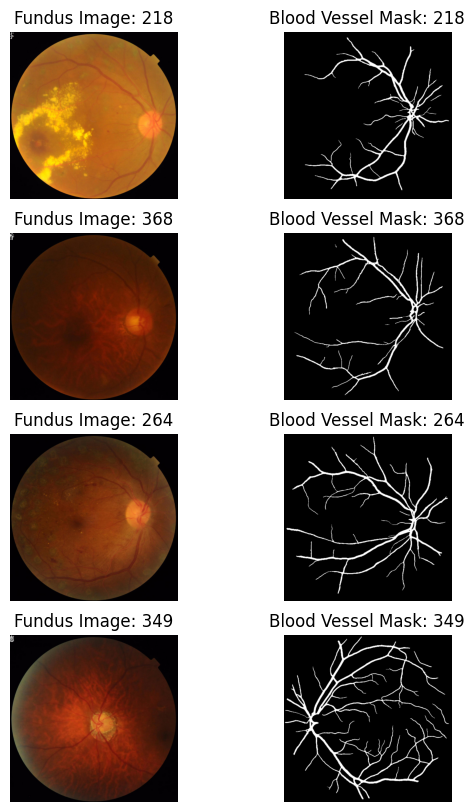

In [ ]:
# Function to display sample images and masks
def plot_images_with_masks(images, masks, num=4):
    plt.figure(figsize=(10, 10))
    for i in range(num):
        idx = random.randint(0, len(images) - 1)
        plt.subplot(num, 3, 3 * i + 1)
        plt.imshow(images[idx])
        plt.title(f"Fundus Image: {idx}")
        plt.axis("off")

        plt.subplot(num, 3, 3 * i + 2)
        plt.imshow(masks[idx], cmap="gray")
        plt.title(f"Blood Vessel Mask: {idx}")
        plt.axis("off")

    plt.show()

# Visualizing images with corresponding masks
plot_images_with_masks(train_images, train_masks, num=4)


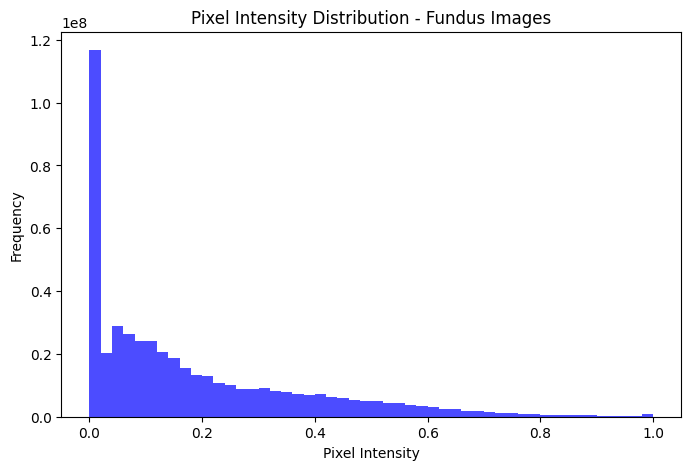

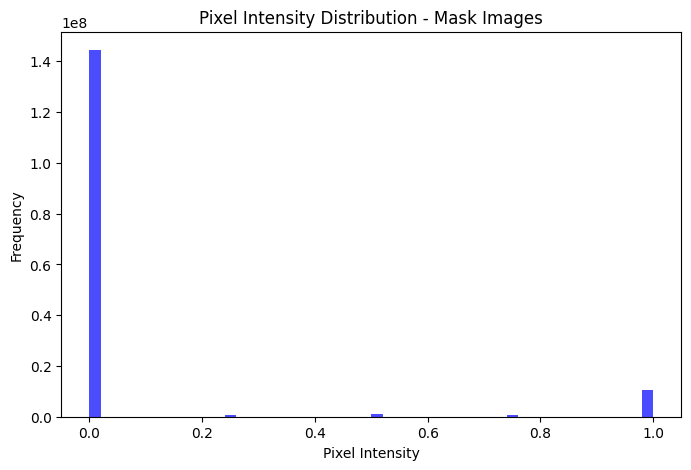

In [ ]:
#Function to plot histogram for pixel intensity analysis
def plot_pixel_distribution(images, title="Pixel Intensity Distribution"):
    plt.figure(figsize=(8, 5))
    plt.hist(images.flatten(), bins=50, color='blue', alpha=0.7)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.show()

# Plot pixel intensity distribution for images and masks
plot_pixel_distribution(train_images, "Pixel Intensity Distribution - Fundus Images")
plot_pixel_distribution(train_masks, "Pixel Intensity Distribution - Mask Images")


## U-Net Training & Testing

In this section we prepare the U-Net model for training. Once, training is completed it will be tested on the test set (200 images) and the final test performance metrics is revealed. All the prediction masks from test set are saved in the resuls folder and visualized in the next section to compare with the W-Net model.

Using device: cuda
Found training images: 480
Found training masks: 480
Found validation images: 120
Found validation masks: 120
Training image example: /content/drive/MyDrive/ITEC 6240 - ML/ML Project/Dataset/FIVES/train/Original/231_D.png
Training mask example: /content/drive/MyDrive/ITEC 6240 - ML/ML Project/Dataset/FIVES/train/Ground truth/231_D.png
Dataset Size:
Train: 480 - Valid: 120

Valid samples count: 480
Valid samples count: 120


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-15-ccd0f192e305>:96: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None


Starting training...
Epoch: 01/20 | Epoch Time: 10m 54s
Train Loss: 1.19508
Val Loss: 0.09653
Epoch: 02/20 | Epoch Time: 2m 19s
Train Loss: 0.98558
Val Loss: 0.07908
Epoch: 03/20 | Epoch Time: 2m 19s
Train Loss: 0.89338
Val Loss: 0.07221
Epoch: 04/20 | Epoch Time: 2m 19s
Train Loss: 0.81478
Val Loss: 0.06659
Epoch: 05/20 | Epoch Time: 2m 19s
Train Loss: 0.75476
Val Loss: 0.06136
Epoch: 06/20 | Epoch Time: 2m 19s
Train Loss: 0.70314
Val Loss: 0.05803
Epoch: 07/20 | Epoch Time: 2m 19s
Train Loss: 0.65514
Val Loss: 0.05296
Epoch: 08/20 | Epoch Time: 2m 19s
Train Loss: 0.61118
Val Loss: 0.05102
Epoch: 09/20 | Epoch Time: 2m 19s
Train Loss: 0.57179
Val Loss: 0.04687
Epoch: 10/20 | Epoch Time: 2m 19s
Train Loss: 0.53243
Val Loss: 0.04436
Epoch: 11/20 | Epoch Time: 2m 19s
Train Loss: 0.49848
Val Loss: 0.04192
Epoch: 12/20 | Epoch Time: 2m 19s
Train Loss: 0.46388
Val Loss: 0.03958
Epoch: 13/20 | Epoch Time: 2m 19s
Train Loss: 0.43351
Val Loss: 0.03690
Epoch: 14/20 | Epoch Time: 2m 19s
Train Lo

100%|██████████| 200/200 [05:49<00:00,  1.75s/it]


Jaccard:  0.7642234702072024
F1:  0.8584521488552685
Recall:  0.8111297193341552
Precision:  0.9257064636806521
Accuracy:  0.9834302711486816
Evaluation results saved to: /content/drive/MyDrive/ITEC 6240 - ML/ML Project/results/unet_evaluation_results.json


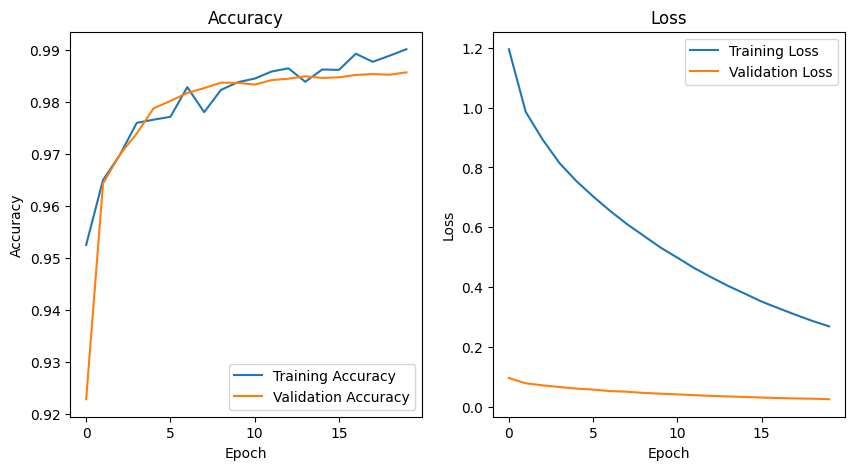

In [ ]:
def main():
    # Seeding for reproducibility
    seeding(42)

    # Create necessary directories
    create_dir("results")

    # Control parameter - set to False to skip training phase
    do_training = True  # Modify this to control whether to perform training

    # Hyperparameters
    H = 512
    W = 512
    size = (H, W)
    batch_size = 10
    # so sig impact for epoch=20, revet back to 10 for best performance
    num_epochs = 20
    lr = 1e-4
    checkpoint_path = "files/checkpoint.pth"

    # Dataset
    train_x = sorted(glob("/content/drive/MyDrive/ITEC 6240 - ML/ML Project/Dataset/FIVES/train/Original/*"))
    train_y = sorted(glob("/content/drive/MyDrive/ITEC 6240 - ML/ML Project/Dataset/FIVES/train/Ground truth/*"))
    train_x = train_x[:600]
    train_y = train_y[:600]


    train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42) # 20% for validation



    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Build model
    model = build_unet()
    model = model.to(device)

    # Training phase - can be skipped
    if do_training:
        # Print file counts for debugging
        print(f"Found training images: {len(train_x)}")
        print(f"Found training masks: {len(train_y)}")
        print(f"Found validation images: {len(valid_x)}")
        print(f"Found validation masks: {len(valid_y)}")

        # Print some example file paths for debugging
        if len(train_x) > 0:
            print(f"Training image example: {train_x[0]}")
        if len(train_y) > 0:
            print(f"Training mask example: {train_y[0]}")

        # Print dataset info
        data_str = f"Dataset Size:\nTrain: {len(train_x)} - Valid: {len(valid_x)}\n"
        print(data_str)

        # Create datasets and data loaders
        train_dataset = DriveDataset(train_x, train_y)
        valid_dataset = DriveDataset(valid_x, valid_y)

        # Check if datasets are empty
        if len(train_dataset) == 0:
            print("Error: Training dataset is empty, cannot continue training!")
            return

        if len(valid_dataset) == 0:
            print("Warning: Validation dataset is empty, will skip validation steps!")

        # Create data loaders
        train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=0,
            pin_memory=True
        )

        valid_loader = DataLoader(
            dataset=valid_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=0,
            pin_memory=True
        )

        # Set optimizer and loss function
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
        loss_fn = DiceBCELoss()

        # Training the model
        best_valid_loss = float("inf")

        # Add mixed precision training to reduce memory usage
        scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

        print("Starting training...")
        for epoch in range(num_epochs):
            start_time = time.time()

            # Use train_loader instead of train_dataset
            train_loss = train(model, train_loader, optimizer, loss_fn, device)

            # Use valid_loader instead of valid_dataset
            valid_loss = evaluate(model, valid_loader, loss_fn, device)

            # Update learning rate
            scheduler.step(valid_loss)

            # Save best model
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss

                # Create save directory
                create_dir("files")

                # Save model
                torch.save(model.state_dict(), checkpoint_path)

            end_time = time.time()
            epoch_mins, epoch_secs = epoch_time(start_time, end_time)

            print(f"Epoch: {epoch+1:02}/{num_epochs} | Epoch Time: {epoch_mins}m {epoch_secs}s")
            print(f"Train Loss: {train_loss:.5f}")
            print(f"Val Loss: {valid_loss:.5f}")

    # Testing phase - always execute
    print("Starting testing...")

    # Check if model file exists
    if not os.path.exists(checkpoint_path):
        print(f"Error: Model file {checkpoint_path} does not exist!")
        print("Please ensure training is completed, or place the trained model file in the correct location.")
        return

    # Load best model
    try:
        model.load_state_dict(torch.load(checkpoint_path, map_location=device))
        print(f"Successfully loaded model: {checkpoint_path}")
    except Exception as e:
        print(f"Error loading model: {e}")
        return

    model.eval()

    # Create results directory
    create_dir("/content/drive/MyDrive/ITEC 6240 - ML/ML Project/results/unet_predictions")

    # Test data
    test_x = sorted(glob("/content/drive/MyDrive/ITEC 6240 - ML/ML Project/Dataset/FIVES/test/Original/*"))
    test_y = sorted(glob("/content/drive/MyDrive/ITEC 6240 - ML/ML Project/Dataset/FIVES/test/Ground truth/*"))

    # Ensure test data exists
    if len(test_x) == 0 or len(test_y) == 0:
        print("Error: Test data is empty!")
        return

    # Print test data info
    print(f"Test images count: {len(test_x)}")
    print(f"Test masks count: {len(test_y)}")

    # Initialize metrics
    metrics_score = []

    # Initialize detailed metrics for each image
    detailed_metrics = []

    # Iterate through test data
    for i, (x, y) in tqdm(enumerate(zip(test_x, test_y)), total=len(test_x)):
        # Read image
        image = cv2.imread(x, cv2.IMREAD_COLOR)
        if image is None:
            print(f"Cannot read image: {x}")
            continue

        # Save original size for later restoration
        original_size = image.shape[:2]  # (height, width)

        # Resize image
        image = cv2.resize(image, (W, H))
        x_tensor = image/255.0
        x_tensor = np.transpose(x_tensor, (2, 0, 1))
        x_tensor = x_tensor.astype(np.float32)
        x_tensor = torch.from_numpy(x_tensor)
        x_tensor = x_tensor.unsqueeze(0)
        x_tensor = x_tensor.to(device)

        # Read mask
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"Cannot read mask: {y}")
            continue

        # Resize mask
        mask = cv2.resize(mask, (W, H))

        # Ensure mask is binary
        if np.max(mask) > 1:
            mask = (mask > 127).astype(np.uint8) * 255

        # Predict
        with torch.no_grad():
            pred_y = model(x_tensor)
            pred_y = torch.sigmoid(pred_y)
            pred_y = pred_y[0].cpu().numpy()
            pred_y = np.squeeze(pred_y, axis=0)
            pred_y = (pred_y > 0.5).astype(np.uint8) * 255

        # Calculate metrics
        mask_norm = mask/255.0
        pred_y_norm = pred_y/255.0

        score = calculate_metrics(mask_norm.flatten(), pred_y_norm.flatten())
        metrics_score.append(score)

        # Save detailed metrics for each image
        image_name = os.path.basename(x)
        detailed_metrics.append({
            "image_name": image_name,
            "jaccard": float(score[0]),
            "f1": float(score[1]),
            "recall": float(score[2]),
            "precision": float(score[3]),
            "accuracy": float(score[4])
        })

        # Prepare visualization
        # Resize all images to the same size
        image = cv2.resize(image, (W, H))
        mask = cv2.resize(mask, (W, H)).astype(np.uint8)
        pred_y = cv2.resize(pred_y, (W, H)).astype(np.uint8)

        # Parse masks for visualization
        ori_mask = mask_parse(mask)
        pred_mask = mask_parse(pred_y)

        # Create concatenated image
        line = np.ones((H, 10, 3)) * 255  # White separator line

        # Concatenate image, ground truth mask, and predicted mask
        cat_images = np.concatenate(
            [image, line, ori_mask, line, pred_mask], axis=1
        )

        # Save result
        cv2.imwrite(f"/content/drive/MyDrive/ITEC 6240 - ML/ML Project/results/unet_predictions/{i}.png", cat_images)

    # Calculate average metrics
    metrics_score = np.array(metrics_score)
    metrics_mean = np.mean(metrics_score, axis=0)

    # Print results
    print("Jaccard: ", metrics_mean[0])
    print("F1: ", metrics_mean[1])
    print("Recall: ", metrics_mean[2])
    print("Precision: ", metrics_mean[3])
    print("Accuracy: ", metrics_mean[4])

    # Create results dictionary
    results = {
        "average_metrics": {
            "jaccard": float(metrics_mean[0]),
            "f1": float(metrics_mean[1]),
            "recall": float(metrics_mean[2]),
            "precision": float(metrics_mean[3]),
            "accuracy": float(metrics_mean[4])
        },
        "detailed_metrics": detailed_metrics,
        "model_info": {
            "model_type": "U-Net",
            "image_size": f"{H}x{W}",
            "batch_size": batch_size,
            "learning_rate": lr,
            "num_epochs": num_epochs,
            "checkpoint_path": checkpoint_path,
            "test_images_count": len(test_x),
            "test_date": time.strftime("%Y-%m-%d %H:%M:%S")
        }
    }

    # Save results to JSON file
    json_path = "/content/drive/MyDrive/ITEC 6240 - ML/ML Project/results/unet_evaluation_results.json"
    with open(json_path, 'w') as f:
        json.dump(results, f, indent=4)

    print(f"Evaluation results saved to: {json_path}")

    # Plot the accuracy and loss curves
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(valid_accuracies, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


if __name__ == "__main__":
    main()

## W-Net Training & Testing

In this section we prepare the W-Net model for training. Once, training is completed it will be tested on the test set (200 images) and the final test performance metrics is revealed. All the prediction masks from test set are saved in the resuls folder and visualized in the next section to compare with the U-Net model.

Found 600 images in train/Original
Found 600 masks in train/Ground truth
Using device: cuda

=== Starting Training Phase ===
Valid samples count: 480
Valid samples count: 120

Training Configuration:
Number of epochs: 20
Batch size: 5 (effective batch size: 20)
Learning rate: 0.001
Image size: 512x512
Device: cuda
Gradient Accumulation Steps: 4
Mixed Precision Training: Enabled
OneCycleLR Scheduler: Enabled

Starting training...


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Error calculating metrics: Classification metrics can't handle a mix of binary and continuous targets


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Error calculating metrics: Classification metrics can't handle a mix of binary and continuous targets

New best model saved with validation loss: 1.20775

Epoch: 01/20 | Epoch Time: 0m 57s
Train Loss: 1.33699
Val Loss: 1.20775
Learning Rate: 1.00e-04


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Error calculating metrics: Classification metrics can't handle a mix of binary and continuous targets


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Error calculating metrics: Classification metrics can't handle a mix of binary and continuous targets

New best model saved with validation loss: 1.07514

Epoch: 02/20 | Epoch Time: 0m 56s
Train Loss: 1.12469
Val Loss: 1.07514
Learning Rate: 1.01e-04


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Error calculating metrics: Classification metrics can't handle a mix of binary and continuous targets


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Error calculating metrics: Classification metrics can't handle a mix of binary and continuous targets

New best model saved with validation loss: 1.00031

Epoch: 03/20 | Epoch Time: 0m 56s
Train Loss: 1.03176
Val Loss: 1.00031
Learning Rate: 1.02e-04


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Error calculating metrics: Classification metrics can't handle a mix of binary and continuous targets


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Error calculating metrics: Classification metrics can't handle a mix of binary and continuous targets

New best model saved with validation loss: 0.95173

Epoch: 04/20 | Epoch Time: 0m 56s
Train Loss: 0.97333
Val Loss: 0.95173
Learning Rate: 1.04e-04


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Error calculating metrics: Classification metrics can't handle a mix of binary and continuous targets


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Error calculating metrics: Classification metrics can't handle a mix of binary and continuous targets

New best model saved with validation loss: 0.91419

Epoch: 05/20 | Epoch Time: 0m 56s
Train Loss: 0.92508
Val Loss: 0.91419
Learning Rate: 1.06e-04


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Error calculating metrics: Classification metrics can't handle a mix of binary and continuous targets


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Error calculating metrics: Classification metrics can't handle a mix of binary and continuous targets

New best model saved with validation loss: 0.87159

Epoch: 06/20 | Epoch Time: 0m 56s
Train Loss: 0.88466
Val Loss: 0.87159
Learning Rate: 1.09e-04


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Error calculating metrics: Classification metrics can't handle a mix of binary and continuous targets


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Error calculating metrics: Classification metrics can't handle a mix of binary and continuous targets

New best model saved with validation loss: 0.83632

Epoch: 07/20 | Epoch Time: 0m 56s
Train Loss: 0.84610
Val Loss: 0.83632
Learning Rate: 1.12e-04


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Error calculating metrics: Classification metrics can't handle a mix of binary and continuous targets


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Error calculating metrics: Classification metrics can't handle a mix of binary and continuous targets

New best model saved with validation loss: 0.80430

Epoch: 08/20 | Epoch Time: 0m 56s
Train Loss: 0.81255
Val Loss: 0.80430
Learning Rate: 1.16e-04


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Error calculating metrics: Classification metrics can't handle a mix of binary and continuous targets


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Error calculating metrics: Classification metrics can't handle a mix of binary and continuous targets

New best model saved with validation loss: 0.77382

Epoch: 09/20 | Epoch Time: 0m 56s
Train Loss: 0.77851
Val Loss: 0.77382
Learning Rate: 1.20e-04


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Error calculating metrics: Classification metrics can't handle a mix of binary and continuous targets


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Error calculating metrics: Classification metrics can't handle a mix of binary and continuous targets

New best model saved with validation loss: 0.74655

Epoch: 10/20 | Epoch Time: 0m 56s
Train Loss: 0.74780
Val Loss: 0.74655
Learning Rate: 1.24e-04


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Error calculating metrics: Classification metrics can't handle a mix of binary and continuous targets


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Error calculating metrics: Classification metrics can't handle a mix of binary and continuous targets

New best model saved with validation loss: 0.71752

Epoch: 11/20 | Epoch Time: 0m 56s
Train Loss: 0.71808
Val Loss: 0.71752
Learning Rate: 1.29e-04


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Error calculating metrics: Classification metrics can't handle a mix of binary and continuous targets


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Error calculating metrics: Classification metrics can't handle a mix of binary and continuous targets

New best model saved with validation loss: 0.68663

Epoch: 12/20 | Epoch Time: 0m 56s
Train Loss: 0.68876
Val Loss: 0.68663
Learning Rate: 1.35e-04


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Error calculating metrics: Classification metrics can't handle a mix of binary and continuous targets


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Error calculating metrics: Classification metrics can't handle a mix of binary and continuous targets

New best model saved with validation loss: 0.65372

Epoch: 13/20 | Epoch Time: 0m 55s
Train Loss: 0.65843
Val Loss: 0.65372
Learning Rate: 1.41e-04


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Error calculating metrics: Classification metrics can't handle a mix of binary and continuous targets


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Error calculating metrics: Classification metrics can't handle a mix of binary and continuous targets

New best model saved with validation loss: 0.62652

Epoch: 14/20 | Epoch Time: 0m 56s
Train Loss: 0.62802
Val Loss: 0.62652
Learning Rate: 1.47e-04


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Error calculating metrics: Classification metrics can't handle a mix of binary and continuous targets


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Error calculating metrics: Classification metrics can't handle a mix of binary and continuous targets

New best model saved with validation loss: 0.59794

Epoch: 15/20 | Epoch Time: 0m 56s
Train Loss: 0.59721
Val Loss: 0.59794
Learning Rate: 1.54e-04


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Error calculating metrics: Classification metrics can't handle a mix of binary and continuous targets


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Error calculating metrics: Classification metrics can't handle a mix of binary and continuous targets

New best model saved with validation loss: 0.56871

Epoch: 16/20 | Epoch Time: 0m 56s
Train Loss: 0.56799
Val Loss: 0.56871
Learning Rate: 1.62e-04


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Error calculating metrics: Classification metrics can't handle a mix of binary and continuous targets


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Error calculating metrics: Classification metrics can't handle a mix of binary and continuous targets

New best model saved with validation loss: 0.53827

Epoch: 17/20 | Epoch Time: 0m 55s
Train Loss: 0.54074
Val Loss: 0.53827
Learning Rate: 1.69e-04


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Error calculating metrics: Classification metrics can't handle a mix of binary and continuous targets


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Error calculating metrics: Classification metrics can't handle a mix of binary and continuous targets

New best model saved with validation loss: 0.51191

Epoch: 18/20 | Epoch Time: 0m 55s
Train Loss: 0.50911
Val Loss: 0.51191
Learning Rate: 1.77e-04


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Error calculating metrics: Classification metrics can't handle a mix of binary and continuous targets


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Error calculating metrics: Classification metrics can't handle a mix of binary and continuous targets

New best model saved with validation loss: 0.48605

Epoch: 19/20 | Epoch Time: 0m 56s
Train Loss: 0.47944
Val Loss: 0.48605
Learning Rate: 1.86e-04


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Error calculating metrics: Classification metrics can't handle a mix of binary and continuous targets


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Error calculating metrics: Classification metrics can't handle a mix of binary and continuous targets

New best model saved with validation loss: 0.45830

Epoch: 20/20 | Epoch Time: 0m 56s
Train Loss: 0.44925
Val Loss: 0.45830
Learning Rate: 1.95e-04

=== Training Completed ===
Best validation loss: 0.45830
Model saved to: files/checkpoint.pth
Starting testing...
Successfully loaded model: files/checkpoint.pth


100%|██████████| 200/200 [01:05<00:00,  3.07it/s]


Jaccard: 0.7709
F1: 0.8635
Recall: 0.8275
Precision: 0.9135
Accuracy: 0.9837
AUC: 0.9109
ROC curve saved to: results/roc_curve.png
Overall AUC: 0.9224
Evaluation results saved to: /content/drive/MyDrive/ITEC 6240 - ML/ML Project/results/evaluation_results.json


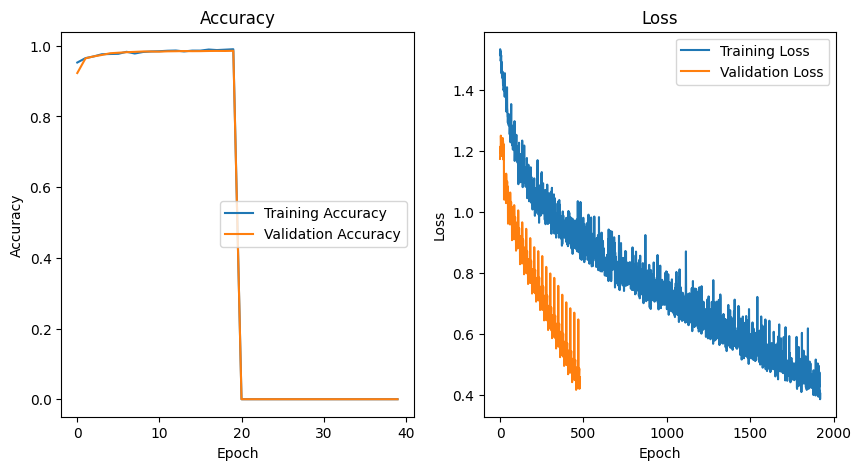

In [ ]:
def main():
    # Seeding for reproducibility
    seeding(42)

    # Create necessary directories
    create_dir("results")

    # Control parameter - set to False to skip training phase
    do_training = True

    # Hyperparameters
    H = 512
    W = 512
    size = (H, W)
    batch_size = 5
    num_epochs = 20
    lr = 1e-3
    checkpoint_path = "files/checkpoint.pth"


    accumulation_steps = 4  # 增加梯度累积步数，相当于批量大小 = 2 * 4 = 8

    # Load all training data
    all_train_x = sorted(glob("/content/drive/MyDrive/ITEC 6240 - ML/ML Project/Dataset/FIVES/train/Original/*"))     # for FIVES dataset
    all_train_y = sorted(glob("/content/drive/MyDrive/ITEC 6240 - ML/ML Project/Dataset/FIVES/train/Ground truth/*"))

    # Print the number of images and masks found
    print(f"Found {len(all_train_x)} images in train/Original")
    print(f"Found {len(all_train_y)} masks in train/Ground truth")
    all_train_x = all_train_x[:600]
    all_train_y = all_train_y[:600]


    # Get base filenames (without path and extension)
    train_x_basenames = [os.path.splitext(os.path.basename(p))[0] for p in all_train_x]
    train_y_basenames = [os.path.splitext(os.path.basename(p))[0] for p in all_train_y]

    # Find matching pairs
    matching_indices = []
    for i, x_basename in enumerate(train_x_basenames):
        if x_basename in train_y_basenames:
            matching_indices.append(i)

    # Filter to keep only matching pairs
    all_train_x = [all_train_x[i] for i in matching_indices]
    all_train_y = [all_train_y[train_y_basenames.index(os.path.splitext(os.path.basename(x))[0])] for x in all_train_x]

    # Split training data into training and validation sets
    train_x, valid_x, train_y, valid_y = train_test_split(all_train_x, all_train_y, test_size=0.2, random_state=42)

    # Test set remains unchanged
    test_x = sorted(glob("/content/drive/MyDrive/ITEC 6240 - ML/ML Project/Dataset/FIVES/test/Original/*"))
    test_y = sorted(glob("/content/drive/MyDrive/ITEC 6240 - ML/ML Project/Dataset/FIVES/test/Ground truth/*"))

    # Set device for training (GPU or CPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Build W-Net model instead of U-Net
    model = build_wnet()
    model = model.to(device)

    # Use W-Net loss function
    loss_fn = WNetLoss(alpha=0.5)

    # Initialize lists to store losses
    train_losses = []
    valid_losses = []

    # Training phase - can be skipped
    if do_training:
        print("\n=== Starting Training Phase ===")

        # Create datasets and data loaders
        train_dataset = DriveDataset(train_x, train_y)
        valid_dataset = DriveDataset(valid_x, valid_y)

        train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=2,  # 增加工作进程数
            pin_memory=True
        )

        valid_loader = DataLoader(
            dataset=valid_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=2,
            pin_memory=True
        )

        # Initialize mixed precision training
        scaler = torch.amp.GradScaler()

        # 优化器使用AdamW并添加权重衰减
        optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=lr,
            weight_decay=0.01,  # 增加权重衰减
            betas=(0.9, 0.999)  # 调整动量参数
        )

        # Initialize best_valid_loss
        best_valid_loss = float("inf")

        # 使用 OneCycleLR 调度器，优化参数
        total_steps = len(train_loader) * num_epochs // accumulation_steps
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=lr,
            total_steps=total_steps,
            pct_start=0.2,  # 更快到达最大学习率
            div_factor=10.0,  # 减小初始学习率的降低幅度
            final_div_factor=100.0,  # 减小最终学习率的降低幅度
            anneal_strategy='cos'  # 使用余弦退火
        )

        print("\nTraining Configuration:")
        print(f"Number of epochs: {num_epochs}")
        print(f"Batch size: {batch_size} (effective batch size: {batch_size * accumulation_steps})")
        print(f"Learning rate: {lr}")
        print(f"Image size: {H}x{W}")
        print(f"Device: {device}")
        print(f"Gradient Accumulation Steps: {accumulation_steps}")
        print("Mixed Precision Training: Enabled")
        print("OneCycleLR Scheduler: Enabled")
        print("\nStarting training...")

        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss = train_wnet(model, train_loader, optimizer, loss_fn, device, train_losses,
                             scaler=scaler, accumulation_steps=accumulation_steps)
            valid_loss = evaluate_wnet(model, valid_loader, loss_fn, device, valid_losses, use_amp=True)

            # 更新学习率（OneCycleLR 不需要监控验证损失）
            if isinstance(scheduler, torch.optim.lr_scheduler.OneCycleLR):
                scheduler.step()
            else:
                scheduler.step(valid_loss)

            # Save best model
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                create_dir("files")  # Create directory for saving model
                torch.save(model.state_dict(), checkpoint_path)  # Save model checkpoint
                print(f"\nNew best model saved with validation loss: {valid_loss:.5f}")

            end_time = time.time()  # End time for epoch
            epoch_mins, epoch_secs = epoch_time(start_time, end_time)  # Calculate epoch time

            print(f"\nEpoch: {epoch+1:02}/{num_epochs} | Epoch Time: {epoch_mins}m {epoch_secs}s")
            print(f"Train Loss: {train_loss:.5f}")
            print(f"Val Loss: {valid_loss:.5f}")
            print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")

        # Plotting the loss curves
        plt.figure(figsize=(12, 6))

        # 计算每个epoch的平均训练损失，使其与验证损失对应
        epoch_size = len(train_loader)
        epochs = len(valid_losses)
        epoch_train_losses = []

        # 确保有足够的训练损失数据
        if len(train_losses) >= epoch_size * epochs:
            for i in range(epochs):
                # 提取当前epoch的训练损失
                start_idx = i * epoch_size
                end_idx = (i+1) * epoch_size
                # 计算当前epoch的平均训练损失
                epoch_loss = sum(train_losses[start_idx:end_idx]) / epoch_size
                epoch_train_losses.append(epoch_loss)

            # 绘制每个epoch的平均损失
            epochs_x = list(range(1, epochs+1))
            plt.plot(epochs_x, epoch_train_losses, 'b-', label='Train Loss (per epoch)', linewidth=2)
            plt.plot(epochs_x, valid_losses, 'r-', label='Validation Loss', linewidth=2)
            plt.xlabel('Epoch')
        else:
            # 如果训练损失数据不足，则直接绘制所有批次的损失
            plt.plot(train_losses, 'b-', alpha=0.5, label='Train Loss (per batch)')

            # 计算每个验证损失对应的批次索引
            batches_per_epoch = len(train_loader)
            valid_indices = [(i+1) * batches_per_epoch - 1 for i in range(len(valid_losses))]

            # 确保索引不超出范围
            valid_indices = [idx for idx in valid_indices if idx < len(train_losses)]

            # 绘制验证损失
            if valid_indices:
                plt.plot(valid_indices, valid_losses[:len(valid_indices)], 'ro-', label='Validation Loss')

            plt.xlabel('Batch')

        # 添加网格线和标题
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.title('Training and Validation Loss')
        plt.ylabel('Loss')
        plt.legend()

        # 保存和显示
        plt.tight_layout()
        plt.savefig('results/loss_curve.png', dpi=300)  # Save loss curve plot
        plt.close()  # 关闭图形以释放内存

        print("\n=== Training Completed ===")
        print(f"Best validation loss: {best_valid_loss:.5f}")
        print(f"Model saved to: {checkpoint_path}")

    # Testing phase
    print("Starting testing...")

    if not os.path.exists(checkpoint_path):
        print(f"Error: Model file {checkpoint_path} does not exist!")
        return

    try:
        model.load_state_dict(torch.load(checkpoint_path, map_location=device))
        print(f"Successfully loaded model: {checkpoint_path}")
    except Exception as e:
        print(f"Error loading model: {e}")
        return

    model.eval()

    create_dir("/content/drive/MyDrive/ITEC 6240 - ML/ML Project/results/image")
    metrics_score = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    detailed_metrics = []
    all_y_true = []
    all_y_pred = []

    for i, (x, y) in tqdm(enumerate(zip(test_x, test_y)), total=len(test_x)):
        try:
            # Read and process image
            image = cv2.imread(x, cv2.IMREAD_COLOR)
            if image is None:
                print(f"Cannot read image: {x}")
                continue

            original_size = image.shape[:2]
            image = cv2.resize(image, (W, H))
            x_tensor = image / 255.0
            x_tensor = np.transpose(x_tensor, (2, 0, 1))
            x_tensor = x_tensor.astype(np.float32)
            x_tensor = torch.from_numpy(x_tensor)
            x_tensor = x_tensor.unsqueeze(0)
            x_tensor = x_tensor.to(device)

            # Read and process mask
            mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                print(f"Cannot read mask: {y}")
                continue

            mask = cv2.resize(mask, (W, H))
            if np.max(mask) > 1:
                mask = (mask > 127).astype(np.uint8) * 255

            # Predict with W-Net
            with torch.no_grad():
                out1, out2 = model(x_tensor)
                # Use the second output (refined prediction)
                pred_y = torch.sigmoid(out2)
                pred_y = pred_y[0].cpu().numpy()
                pred_y = np.squeeze(pred_y, axis=0)
                pred_y = (pred_y > 0.5).astype(np.uint8) * 255

            # Calculate metrics
            mask_norm = mask / 255.0
            pred_y_norm = pred_y / 255.0

            score = calculate_metrics_wnet(mask_norm.flatten(), pred_y_norm.flatten())
            metrics_score = list(map(add, metrics_score, score))

            # Save detailed metrics
            image_name = os.path.basename(x)
            image_metrics = {
                "image_name": image_name,
                "jaccard": score[0],
                "f1": score[1],
                "recall": score[2],
                "precision": score[3],
                "accuracy": score[4],
                "auc": score[5]
            }
            detailed_metrics.append(image_metrics)

            # Store predictions for ROC curve
            all_y_true.append(mask_norm.flatten())
            all_y_pred.append(pred_y_norm.flatten())

            # Visualization
            image = cv2.resize(image, (W, H))
            mask = cv2.resize(mask, (W, H)).astype(np.uint8)
            pred_y = cv2.resize(pred_y, (W, H)).astype(np.uint8)

            ori_mask = mask_parse(mask)
            pred_mask = mask_parse(pred_y)

            line = np.ones((H, 10, 3)) * 255
            cat_images = np.concatenate(
                [image, line, ori_mask, line, pred_mask], axis=1
            )

            cv2.imwrite(f"results/image/{i}.png", cat_images)

        except Exception as e:
            print(f"Error processing image {x}: {e}")
            continue

    # Calculate average metrics
    if len(test_x) > 0:
        jaccard = metrics_score[0] / len(test_x)
        f1 = metrics_score[1] / len(test_x)
        recall = metrics_score[2] / len(test_x)
        precision = metrics_score[3] / len(test_x)
        accuracy = metrics_score[4] / len(test_x)
        auc_score = metrics_score[5] / len(test_x)
    else:
        jaccard, f1, recall, precision, accuracy, auc_score = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

    # Print results
    print(f"Jaccard: {jaccard:.4f}")
    print(f"F1: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC: {auc_score:.4f}")

    # Combine all predictions for overall ROC curve
    if all_y_true and all_y_pred:  # Check if lists are not empty
        all_y_true = np.concatenate(all_y_true)  # Concatenate true labels
        all_y_pred = np.concatenate(all_y_pred)  # Concatenate predicted labels

        # Plot and save ROC curve
        roc_path = "results/roc_curve.png"
        overall_auc = plot_roc_curve(all_y_true, all_y_pred, save_path=roc_path)  # Plot ROC curve
        print(f"Overall AUC: {overall_auc:.4f}")
    else:
        print("Warning: No data available for ROC curve")
        overall_auc = 0.0

    # Create results dictionary
    results = {
        "average_metrics": {
            "jaccard": float(jaccard),
            "f1": float(f1),
            "recall": float(recall),
            "precision": float(precision),
            "accuracy": float(accuracy),
            "auc": float(auc_score)
        },
        "detailed_metrics": detailed_metrics,
        "model_info": {
            "model_type": "W-Net",
            "image_size": f"{H}x{W}",
            "batch_size": batch_size,
            "learning_rate": lr,
            "num_epochs": num_epochs,
            "checkpoint_path": checkpoint_path,
            "test_images_count": len(test_x),
            "test_date": time.strftime("%Y-%m-%d %H:%M:%S")
        }
    }

    # Save results to JSON file
    json_path = "/content/drive/MyDrive/ITEC 6240 - ML/ML Project/results/evaluation_results.json"
    with open(json_path, 'w') as f:
        json.dump(results, f, indent=4)  # Save results in JSON format

    print(f"Evaluation results saved to: {json_path}")  # Print path to saved results


    # Plot the accuracy and loss curves
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(valid_accuracies, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


if __name__ == "__main__":
    main()  # Execute the main function

## Predictions Visulization

In this section we take a look at the predictions from both models and compare the masks vs ground truth.

In [ ]:
prediction_unet = sorted(glob("/content/drive/MyDrive/ITEC 6240 - ML/ML Project/results/unet predictions/*"))
prediction_wnet = sorted(glob("/content/drive/MyDrive/ITEC 6240 - ML/ML Project/results/wnet predictions/*"))

In [ ]:
import random
import matplotlib.pyplot as plt
import cv2

def visualize_random_predictions(prediction_unet, prediction_wnet, num_images=5):
  """Visualizes random predictions from two sets of prediction masks."""

  num_predictions = len(prediction_unet)
  random_indices = random.sample(range(num_predictions), num_images)

  # Adjust the number of rows and columns for the desired layout
  # **changed to num_images * 2 to accommodate two rows per prediction**
  fig, axes = plt.subplots(num_images * 2, 1, figsize=(15, num_images * 15))

  # Iterate over random indices and display predictions with new layout
  for i, index in enumerate(random_indices):
    unet_mask = cv2.imread(prediction_unet[index], cv2.IMREAD_COLOR)
    wnet_mask = cv2.imread(prediction_wnet[index], cv2.IMREAD_COLOR)
    #diff_mask = cv2.absdiff(unet_mask, wnet_mask)

    # Calculate the row indices for this image set
    row_unet = i * 2  # Row for U-Net prediction
    row_wnet = i * 2 + 1  # Row for W-Net prediction
    #row_diff = i * 3 + 2  # Row for difference image

    # Display U-Net prediction
    axes[row_unet].imshow(cv2.cvtColor(unet_mask, cv2.COLOR_BGR2RGB))
    axes[row_unet].set_title(f'U-Net Prediction {index}\n\n Fundas image -- Ground truth mask -- Predicted mask')
    axes[row_unet].axis('off')

    # Display W-Net prediction
    axes[row_wnet].imshow(cv2.cvtColor(wnet_mask, cv2.COLOR_BGR2RGB))
    axes[row_wnet].set_title(f'W-Net Prediction {index}\n\n Fundas image -- Ground truth mask -- Predicted mask')
    axes[row_wnet].axis('off')

    # Display difference image
    #axes[row_diff].imshow(cv2.cvtColor(diff_mask, cv2.COLOR_BGR2RGB))
    #axes[row_diff].set_title(f'U-Net - W-Net {index}')
    #axes[row_diff].axis('off')

  plt.show()

# Let's see the predictions
visualize_random_predictions(prediction_unet, prediction_wnet)

Output hidden; open in https://colab.research.google.com to view.